In [20]:
from model import eccv16
from dataset import MangaDataset

import torch
import torch.nn as nn

import torch.optim as optim

from skimage import color
from PIL import Image
import numpy as np

from torch.utils.tensorboard import SummaryWriter

In [21]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

EPOCHS = 10
BATCH_SIZE = 8

trainDataset = MangaDataset('../colorization-av-enseirb-2020/dataset/one_piece', train=True)

trainLoader = torch.utils.data.DataLoader(trainDataset,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=4)

testDataset = MangaDataset('../colorization-av-enseirb-2020/dataset/one_piece', train=False)

testLoader = torch.utils.data.DataLoader(testDataset,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=4)


colorizer_eccv16 = eccv16(pretrained=True).eval().to(device)

writer = SummaryWriter()

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(colorizer_eccv16.parameters(), lr=3.16e-5, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.001)

In [11]:
for epoch in range(EPOCHS):
    total_running_loss = 0.0
    total = 0
    for i, batch in enumerate(trainLoader, 0):

        ipt, target = batch
        ipt, target = ipt.to(device), target.to(device)


        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = colorizer_eccv16(ipt)

        loss = criterion(target, outputs)
        loss.backward()
        optimizer.step()
        
        # print statistics
        total_running_loss += loss.item()
        total += 1
        
    with torch.no_grad():
        colorizer_eccv16.eval()
        total_test_loss = 0.0
        total_test = 0
        for i_tst, batch_test in enumerate(testLoader, 0):
            ipt_tst, target_tst = batch_test
            ipt_tst, target_tst = ipt_tst.to(device), target_tst.to(device)

            y_pred = colorizer_eccv16(ipt_tst)
            total_test_loss += criterion(target_tst, y_pred).item()
            total_test += 1

        colorizer_eccv16.train()

    print("avg running", total_running_loss/float(total))
    print("avg test", total_test_loss/float(total_test))

    writer.add_scalar('train_loss', total_running_loss/float(total), epoch)
    writer.add_scalar('test_loss', total_test_loss/float(total_test), epoch)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
avg running 158.23360631799184
avg test 5.678376978093928
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


KeyboardInterrupt: 

In [ ]:
torch.save(colorizer_eccv16.state_dict(), 'model.pt')

In [16]:
batch = next(iter(trainLoader))
ipt, target = batch
ipt, target = ipt.to('cpu'), target.to('cpu')

In [17]:
cpu_model = colorizer_eccv16.to('cpu')

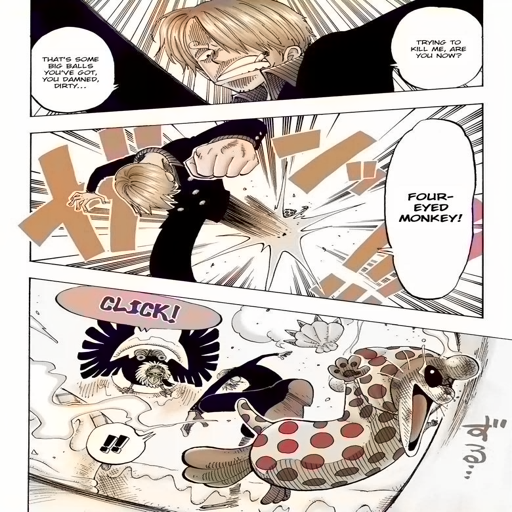

In [18]:
y_pred = cpu_model(ipt)
out_lab_orig = torch.cat((ipt, y_pred), dim=1)

o=color.lab2rgb(out_lab_orig[2].unsqueeze(0).data.cpu().numpy()[0,...].transpose((1,2,0)))
im = Image.fromarray(np.uint8(o*255))

im

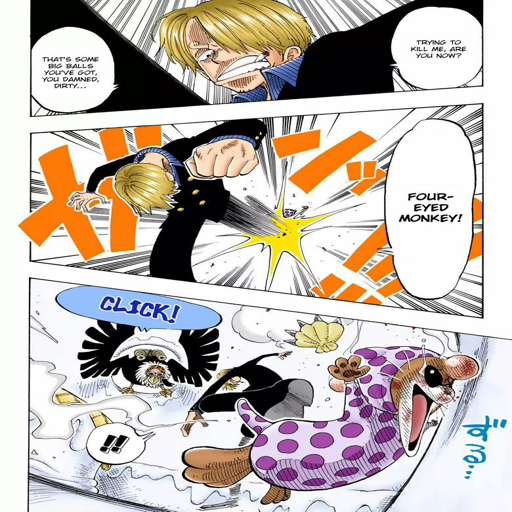

In [19]:
out_lab_orig = torch.cat((ipt, target), dim=1)
o=color.lab2rgb(out_lab_orig[2].unsqueeze(0).data.cpu().numpy()[0,...].transpose((1,2,0)))
im = Image.fromarray(np.uint8(o*255))
im

In [ ]:
# For the real manga.... It will be harder than that :)

out_np = np.asarray(Image.open('./dataset/one_piece/bw/chapter_1_1.png').resize((512,512), resample=3))
img_l_orig = color.rgb2lab(out_np)[:,:,0]
tens_orig_l = torch.Tensor(img_l_orig).unsqueeze(0).unsqueeze(0)

y_pred = cpu_model(tens_orig_l)
out_lab_orig = torch.cat((tens_orig_l, y_pred), dim=1)

o=color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))
im = Image.fromarray(np.uint8(o*255))